** PREDICT BITCOIN WITH RNN-LSTM IN KERAS**







---







Importing the libraries:




In [0]:
import datetime
import time
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [0]:

neurons = 512                 # number of hidden units in the LSTM layer
activation_function = 'tanh'  # activation function for LSTM and Dense layer
loss = 'mse'                  # loss function for calculating the gradient, in this case Mean Squared Error
optimizer= 'adam'             # optimizer for applying gradient decent
dropout = 0.25                # dropout ratio used after each LSTM layer to avoid overfitting
batch_size = 128              
epochs = 53                  
window_len = 7               # is an intiger to be used as the look back window for creating a single input sample.
size = 0.8           # porportion of data to be used for training
merge_date = '2018-01-01'     # the earliest date which we have data for both ETH and BTC or any other provided coin

Getting the data -  historical data from www.coinmarketcap.com

In [0]:
def get_historical_data(market, tag = True):   
  """
  This function will use the coinmarketcap.com url for provided coin/token page. 
  The function reads the Open, High, Low, Close Prices and Volume indicators (OHLCV) and Market cap.
  Convert any non-numeric values to numeric.
  If a tag name is provided, the tag name will be added to every column.
  Returns: A Pandas DataFrame
  
  """
  market_dataframe = pd.read_html("https://coinmarketcap.com/currencies/" + market + "/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
  #print(market_dataframe.head(5))
  #market_dataframe = market_dataframe.assign(Date=pd.to_datetime(market_dataframe['Date']))  
  market_dataframe = market_dataframe.assign(Date= pd.to_datetime(market_dataframe['Date'])) # convert date to numeric.
  print(market_dataframe.head(5))
  market_dataframe['Volume'] = (pd.to_numeric(market_dataframe['Volume'], errors='coerce').fillna(0)) # convert any missing values to zero.
  if tag:
    market_dataframe.columns = [market_dataframe.columns[0]] + [tag + '_' + i for i in market_dataframe.columns[1:]]
    market_dataframe.rename(columns={tag+'_'+'Open*': tag+'_'+'Open', tag+'_'+'Close**': tag+'_'+'Close'}, inplace=True)

  return market_dataframe
  

In [102]:
btc_data = get_historical_data('bitcoin',tag = 'BTC')
btc_data.head(5)

        Date    Open*     High      Low  Close**      Volume    Market Cap
0 2018-07-17  6739.65  7387.24  6684.17  7321.04  5961950000  115602000000
1 2018-07-16  6357.01  6741.75  6357.01  6741.75  4725800000  109029000000
2 2018-07-15  6272.70  6403.46  6256.51  6359.64  3285460000  107573000000
3 2018-07-14  6247.50  6298.19  6212.22  6276.12  2923670000  107130000000
4 2018-07-13  6235.03  6310.55  6192.24  6238.05  3805400000  106906000000


,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market Cap
0,2018-07-17,6739.65,7387.24,6684.17,7321.04,5.961950e+09,115602000000
1,2018-07-16,6357.01,6741.75,6357.01,6741.75,4.725800e+09,109029000000
2,2018-07-15,6272.70,6403.46,6256.51,6359.64,3.285460e+09,107573000000
3,2018-07-14,6247.50,6298.19,6212.22,6276.12,2.923670e+09,107130000000
4,2018-07-13,6235.03,6310.55,6192.24,6238.05,3.805400e+09,106906000000


DATA PREPARATION:


1.   Dealing with Missing values. ( Replace them with a zero)
2.   Removing unnecessary columns ( Feature selection)
3.   Sort the data based on date. (Most recent first)
4.   Split the data for training and testing
5.   Convert the data to a numpy array



In [0]:
# Missing values have been dealt with in the previous function.

def feature_selection(data):
  """
  This function drops unnecessary columns and sorts the dataframe in descending order based on the date (most recent first)
  
  
  """
  data = data[['Date']+[coin+metric for coin in ['BTC_', 'ETH_'] for metric in ['Close','Volume']]]
  data = data.sort_values(by='Date')
  return data

In [0]:
def merge_data(a,b,from_date = merge_date):
  """
  a: first DataFrame
  b: second DataFrame
  from_date: includes the data from the provided date and drops the any data before that date.
  returns merged data as Pandas DataFrame
  """
  
  merged_data = pd.merge(a, b, on=['Date'])
  merged_data = merged_data[merged_data['Date']>=from_date]
  return merged_data

In [0]:
def add_volatility(data, coins=['BTC', 'ETH']):
  """
  data: input data, pandas DataFrame
  coins: default is for 'btc and 'eth'. It could be changed as needed
  This function calculates the volatility and close_off_high of each given coin in 24 hours, 
  and adds the result as new columns to the DataFrame.
  Return: DataFrame with added columns
  """
  for coin in coins:
    # calculate the daily change
    kwargs = {coin + '_change': lambda x: (x[coin + '_Close'] - x[coin + '_Open']) / x[coin + '_Open'],
             coin + '_close_off_high': lambda x: 2*(x[coin + '_High'] - x[coin + '_Close']) / (x[coin + '_High'] - x[coin + '_Low']) - 1,  #close-off-high
             coin + '_volatility': lambda x: (x[coin + '_High'] - x[coin + '_Low']) / (x[coin + '_Open'])}
    data = data.assign(**kwargs)
  return data

In [0]:
def split_data(data,size = 0.8):
  """
  size: proportion of the data to be used for training
  This function splits the data into training_set and test_set based on the given training_size
  Return: train_set and test_set as pandas DataFrame
  """
  
  return data[:int(size*len(data))], data[int(training_size*len(data)):]


In [0]:
def create_inputs(data,coins = ['BTC','ETH'],window_len = window_len):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coins: coin datas which will be used as the input. Default is 'btc', 'eth' (Bitcoin and Ethereum).
  window_len: is an integer to be used as the look back window for creating a single input sample.
  This function will create input array X from the given dataset and will normalize 'Close' and 'Volume' between 0 and 1
  Return: X, the input for our model as a python list which later needs to be converted to numpy array.
  
  """
  
  norm_cols = [coin + metric for coin in coins for metric in ['_Close', '_Volume']]  # columns to be normalized.
  #input = []
  inputs = []
  for i in range(len(data) - window_len):
    temp_set = data[i:(i + window_len)].copy()
    inputs.append(temp_set)
    for col in norm_cols:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
  return inputs
  
  
  

In [0]:
def create_outputs(data, coin, window_len=window_len):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coin: the target coin in which we need to create the output labels for
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create the labels array for our training and validation and normalize it between 0 and 1
  Return: Normalized numpy array for 'Close' prices of the given coin
  """
  return (data[coin + '_Close'][window_len:].values / data[coin + '_Close'][:-window_len].values) - 1

In [0]:
def to_array(data):
  """
  data: DataFrame
  This function will convert list of inputs to a numpy array
  Return: numpy array
  """
  x = [np.array(data[i]) for i in range (len(data))]
  return np.array(x)


In [0]:
def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  """
  inputs: input data as numpy array
  output_size: number of predictions per input sample
  neurons: number of neurons/ units in the LSTM layer
  active_func: Activation function to be used in LSTM layers and Dense layer
  dropout: dropout ration, default is 0.25
  loss: loss function for calculating the gradient
  optimizer: type of optimizer to backpropagate the gradient
  This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
  and finally a dense layer to produce the output using keras' sequential model.
  Return: Keras sequential model and model summary
  """
  model = Sequential()
  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
  model.summary()
  return model

In [0]:
def show_plot(data, tag):
  fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
  ax1.set_ylabel('Closing Price ($)',fontsize=12)
  ax2.set_ylabel('Volume ($ bn)',fontsize=12)
  ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
  ax2.set_yticklabels(range(10))
  ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax1.set_xticklabels('')
  ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
  ax1.plot(data['Date'].astype(datetime.datetime),data[tag +'_Open'])
  ax2.bar(data['Date'].astype(datetime.datetime).values, data[tag +'_Volume'].values)
  fig.tight_layout()
  plt.show()
  

In [0]:
def date_labels():
  last_date = market_data.iloc[0, 0]
  date_list = [last_date - datetime.timedelta(days=x) for x in range(len(X_test))]
  return[date.strftime('%m/%d/%Y') for date in date_list][::-1]

In [0]:
def plot_results(history, model, Y_target, coin):
  plt.figure(figsize=(25, 20))
  plt.subplot(311)
  plt.plot(history.epoch, history.history['loss'], )
  plt.plot(history.epoch, history.history['val_loss'])
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss')
  plt.title(coin + ' Model Loss')
  plt.legend(['Training', 'Test'])

  plt.subplot(312)
  plt.plot(Y_target)
  plt.plot(model.predict(X_train))
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Training Set')
  plt.legend(['Actual','Predicted'])

  ax1 = plt.subplot(313)
  plt.plot(test_set[coin + '_Close'][window_len:].values.tolist())
  plt.plot(((np.transpose(model.predict(X_test)) + 1) * test_set[coin + '_Close'].values[:-window_len])[0])
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Test Set')
  plt.legend(['Actual','Predicted'])
  
  date_list = date_labels()
  ax1.set_xticks([x for x in range(len(date_list))])
  for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
    label.set_visible(False)

  plt.show()

In [114]:
btc_data = get_historical_data("bitcoin", tag='BTC')
eth_data = get_historical_data("ethereum", tag='ETH')

        Date    Open*     High      Low  Close**      Volume    Market Cap
0 2018-07-17  6739.65  7387.24  6684.17  7321.04  5961950000  115602000000
1 2018-07-16  6357.01  6741.75  6357.01  6741.75  4725800000  109029000000
2 2018-07-15  6272.70  6403.46  6256.51  6359.64  3285460000  107573000000
3 2018-07-14  6247.50  6298.19  6212.22  6276.12  2923670000  107130000000
4 2018-07-13  6235.03  6310.55  6192.24  6238.05  3805400000  106906000000
        Date   Open*    High     Low  Close**      Volume   Market Cap
0 2018-07-17  480.08  508.78  468.92   501.00  2288100000  48360500000
1 2018-07-16  450.43  480.66  446.80   480.66  1858680000  45364300000
2 2018-07-15  435.88  454.00  433.92   449.85  1350160000  43890800000
3 2018-07-14  434.51  439.43  431.47   436.09  1235820000  43743700000
4 2018-07-13  430.74  442.36  430.74   434.03  1489670000  43355400000


In [115]:
eth_data.head()


,Date,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,ETH_Market Cap
0,2018-07-17,480.08,508.78,468.92,501.00,2288100000,48360500000
1,2018-07-16,450.43,480.66,446.80,480.66,1858680000,45364300000
2,2018-07-15,435.88,454.00,433.92,449.85,1350160000,43890800000
3,2018-07-14,434.51,439.43,431.47,436.09,1235820000,43743700000
4,2018-07-13,430.74,442.36,430.74,434.03,1489670000,43355400000


In [116]:
btc_data.head()


,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market Cap
0,2018-07-17,6739.65,7387.24,6684.17,7321.04,5.961950e+09,115602000000
1,2018-07-16,6357.01,6741.75,6357.01,6741.75,4.725800e+09,109029000000
2,2018-07-15,6272.70,6403.46,6256.51,6359.64,3.285460e+09,107573000000
3,2018-07-14,6247.50,6298.19,6212.22,6276.12,2.923670e+09,107130000000
4,2018-07-13,6235.03,6310.55,6192.24,6238.05,3.805400e+09,106906000000


In [0]:

market_data  = merge_data(btc_data, eth_data)
model_data = feature_selection(market_data)
train_set, test_set = split_data(model_data)

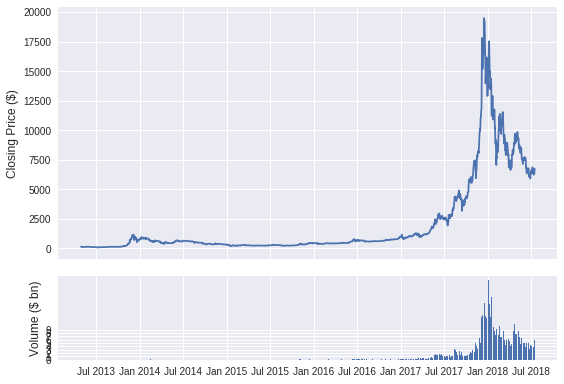

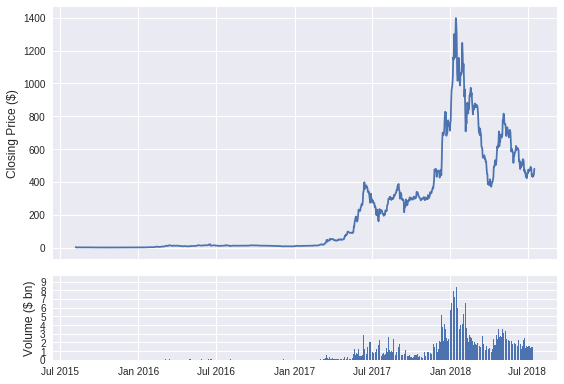

In [118]:
show_plot(btc_data, tag='BTC')
show_plot(eth_data, tag='ETH')

In [119]:

train_settrain_se  = train_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

X_train = create_inputs(train_set)
Y_train_btc = create_outputs(train_set, coin='BTC')
X_test = create_inputs(test_set)
Y_test_btc = create_outputs(test_set, coin='BTC')

Y_train_eth = create_outputs(train_set, coin='ETH')
Y_test_eth = create_outputs(test_set, coin='ETH')

X_train, X_test = to_array(X_train), to_array(X_test)

print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_btc), np.shape(Y_test_btc))
print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_eth), np.shape(Y_test_eth))

(151, 7, 5) (33, 7, 4) (151,) (33,)
(151, 7, 5) (33, 7, 4) (151,) (33,)


In [122]:
# clean up the memory
gc.collect()
# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
btc_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
btc_history = btc_model.fit(X_train, Y_train_btc, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_btc), shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 7, 512)            1060864   
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 512)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 7, 512)            2099200   
_________________________________________________________________
dropout_14 (Dropout)         (None, 7, 512)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
__________

ValueError: ignored